# Save to numpy data

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Import neccessary libraries

In [2]:
import os
import sys
import glob
import cv2

import pandas as pd
import numpy as np
from natsort import natsorted
import shutil

import ipyvolume as ipv

import matplotlib
from scipy.interpolate import griddata
matplotlib.use('TkAgg')
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.colors import Normalize

%matplotlib notebook 

# Global setups

In [27]:
# Global variables
vth_dir = 'data/VB_0519/VTH/'
z_dir = 'data/VB_0519/Z/'
h_dir = 'data/VB_0519/H/'

dimx = 465 + 2
dimy = 324 + 2
dimt = 1

# vth_name = 'vth'+'_'+str(dimt).zfill(4) \
#                 +'_'+str(dimy).zfill(4) \
#                 +'_'+str(dimx).zfill(4)+'.npy'
# z_name   =   'z'+'_'+str(dimt).zfill(4) \
#                 +'_'+str(dimy).zfill(4) \
#                 +'_'+str(dimx).zfill(4)+'.npy'
# h_name   =   'z'+'_'+str(dimt).zfill(4) \
#                 +'_'+str(dimy).zfill(4) \
#                 +'_'+str(dimx).zfill(4)+'.npy'
# print(vth_name)
# print(z_name)
# print(h_name)

vth_files = natsorted(glob.glob(os.path.join(vth_dir, '*.dat')))
z_files = natsorted(glob.glob(os.path.join(z_dir, '*.grd')))
h_files = natsorted(glob.glob(os.path.join(h_dir, '*.grd')))

debug = False
 

# Parse *.dat and *.grd files

In [28]:
######################################################################
def parse_dat(file_name, verbose=True):
    if verbose: print(file_name)
    dat_str = np.genfromtxt(file_name, delimiter = '\t', dtype='unicode')
#     if verbose: 
#         print(dat_str[0])
#         print(dat_str[0][0], dat_str[0][1], dat_str[0][2], dat_str[0][3], dat_str[0][4])
        
    dat = []
    for row in dat_str:
        num = list(map(float, row))
        dat.append(num)
#         if verbose and row[3] != '0': 
#             print(row)
#             print(row[0], row[1], row[2], row[3], row[4])
    if verbose: 
        print(row)
        print(num)
    dat = np.array(dat, dtype=np.float32)
    if verbose: print(dat.shape)
    return dat

######################################################################
def parse_grd(file_name, verbose=True):
    grd_str = np.genfromtxt(file_name, delimiter = ' ', dtype='unicode')
    if verbose: print(grd_str.shape)
    if verbose: print(grd_str[:5])
    grd = []
    for row in grd_str[5:]: # Parse from the line number 5th
        grd.append(np.float32(row.split()))
    grd = np.array(grd, dtype=np.float32)
    if verbose: print(grd.shape)
    return grd

# Drawing with mplot3d here

<IPython.core.display.Javascript object>


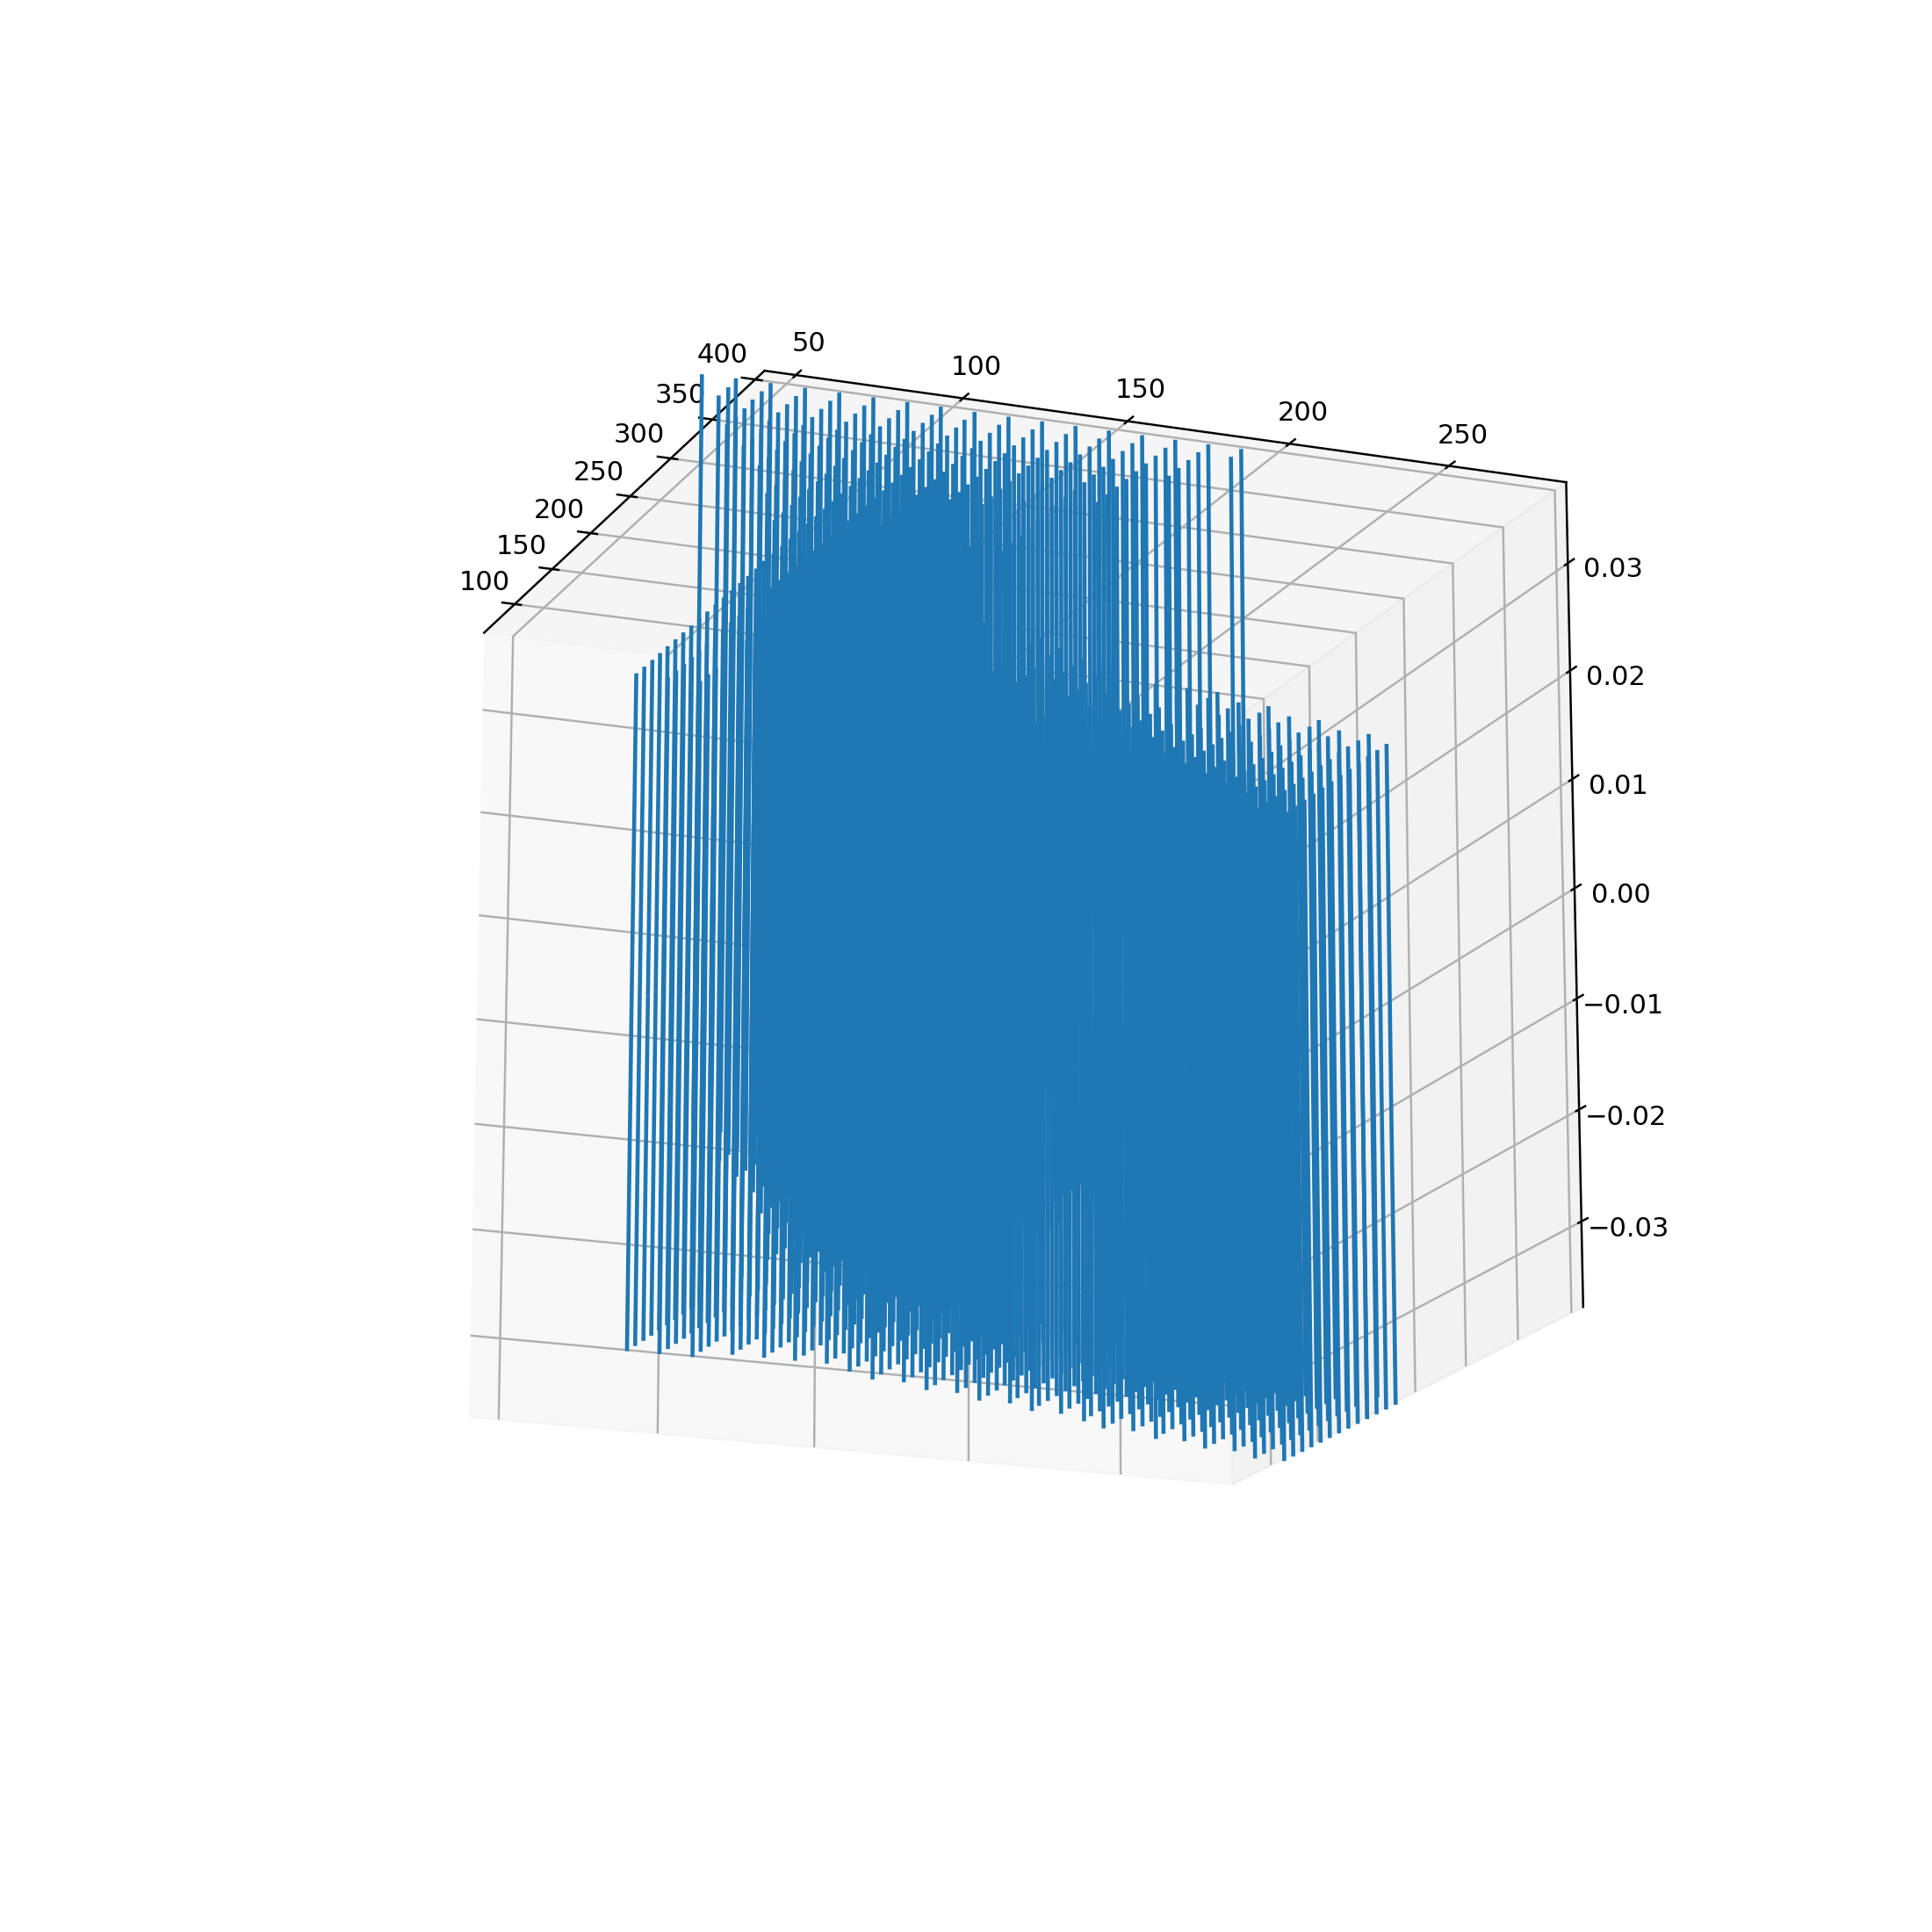

data/VB_0519/VTH/VTH 101h.dat
['363600' '465' '324' '0' '0']
[363600.0, 465.0, 324.0, 0.0, 0.0]
(149872, 5)
(328, 469, 1) (328, 469, 1) (328, 469, 1)
(328, 469, 1) (328, 469, 1) (328, 469, 1)


In [56]:
######################################################################
# fig = plt.figure(figsize=(10, 10))
# ax = fig.gca(projection='3d')


shutil.rmtree('result', ignore_errors=True)
os.makedirs('result')
###################################################################### 
sample=100
for t in range(sample,sample+1):
    # Ensure that the next plot doesn't overwrite the first plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    plt.gcf()
    ######################################################################
    # Read the data
    vth_data = parse_dat(vth_files[t], verbose=True).astype(np.float32)
    

    z_data = parse_grd(z_files[t], verbose=debug).astype(np.float32)
    h_data = parse_grd(h_files[0], verbose=debug).astype(np.float32)
    
    # Resize the z and h_data
    z_data = cv2.resize(z_data, (dimx, dimy))
    h_data = cv2.resize(h_data, (dimx, dimy))
    
    x_data, y_data = np.meshgrid(range(dimx), range(dimy))
    
#     #Plot the surface of minus depth
#     ax.plot_surface(x_data, y_data, -h_data, 
#                     cmap=plt.cm.gist_ncar_r, 
#                     alpha=1)
    
    
    ######################################################################
    # Calculate the magnitudes and the phases
    m_data = np.zeros_like(z_data)
    d_data = np.zeros_like(z_data)
    
    for k in range(vth_data.shape[0]):
        m_data[vth_data[k,2].astype(np.int32), 
               vth_data[k,1].astype(np.int32)] = vth_data[k,3]
        d_data[vth_data[k,2].astype(np.int32), 
               vth_data[k,1].astype(np.int32)] = vth_data[k,4]

    # Calculate the u and v components
    u_data = m_data*np.cos(d_data * np.pi / 180.)
    v_data = m_data*np.sin(d_data * np.pi / 180.)    
    b_data = np.zeros_like(d_data) # background or 0
#     #Plot the surface of water level
#     ax.plot_surface(x_data, y_data, m_data, 
#                     cmap=plt.cm.summer_r, 
#                     alpha=0.4)
    # Color the phase of each vector
    norm = Normalize()
    #norm.autoscale(m_data.flatten())
    cmap = plt.cm.PiYG #PiYG #BuGn
    
    # Grid setups
    xx, yy, zz = np.meshgrid(range(dimx), range(dimy), range(1))    
    zz = np.zeros_like(zz)
    #zz = np.expand_dims(z_data, -1)
    ut = np.expand_dims(u_data, -1)
    vt = np.expand_dims(v_data, -1)
    wt = np.zeros_like(zz)
    
    print(xx.shape, yy.shape, zz.shape)
    print(ut.shape, vt.shape, wt.shape)
    

    s = 10 # stride
    i = t%s # For alternating the quiver
    dict_pivot = {0: 'tail', 
                  1: 'middle', 
                  2: 'tip'}
    ax.quiver3D(xx[i::s,i::s,:], 
                yy[i::s,i::s,:], 
                zz[i::s,i::s,:], 
                
                ut[i::s,i::s,:],
                vt[i::s,i::s,:],
                wt[i::s,i::s,:],
                length=0.5, 
                normalize=True, 
                arrow_length_ratio=0.25,
                pivot= dict_pivot[i], #'tail', 
                norm=colors.LogNorm(vmin=d_data.min(),vmax=d_data.max())
                #normalize=True,
                #color=cmap(norm.auto(m_data.flatten())),
                #cmap=cm.PiYG, 
                #norm=colors.LogNorm(vmin=rad.min(),vmax=rad.max())
              #pivot='tail', 
              #color=cmap(norm(rad.flatten())),
              #length=0.1,
              #lw=2,
              #normalize=False,
              #arrow_length_ratio=0.1,
              )
    ######################################################################
    # Plot
    ax.azim = -90#-60 #-90 #120 
    ax.elev = 90#30 #90 #60 
    ax.dist = 10 #10 #5
    
    ax.set_xlim3d(0, dimx)
    ax.set_ylim3d(0, dimy)
    #ax.set_zlim3d(-40, 10)
    
    plt.show()

In [14]:
print(ax.azim, ax.elev, ax.dist)

-60 30 10


In [7]:
# fig = plt.figure()
# ax = fig.gca(projection='3d')

# # Make the grid
# x, y, z = np.meshgrid(np.arange(-0.8, 1, 0.2),
#                       np.arange(-0.8, 1, 0.2),
#                       np.arange(-0.8, 1, 0.2))

# # Make the direction data for the arrows
# u = np.sin(np.pi * x) * np.cos(np.pi * y) * np.cos(np.pi * z)
# v = -np.cos(np.pi * x) * np.sin(np.pi * y) * np.cos(np.pi * z)
# w = (np.sqrt(2.0 / 3.0) * np.cos(np.pi * x) * np.cos(np.pi * y) *
#      np.sin(np.pi * z))

# ax.quiver(x, y, z, u, v, z, length=0.1, normalize=True)

# plt.show()

In [33]:
print(vth_data.dtype)
print(np.max(vth_data[:,1]))
print(np.max(vth_data[:,2]))

print(np.min(vth_data[:,1]))
print(np.min(vth_data[:,2]))

print(m_data.shape)
print(len(vth_data))
print(325*466)
# print(x.shape, x)
# print(y.shape, y)
# print(z.shape, z)
# print(u.shape, u)
# print(v.shape, v)
# print(w.shape, w)

float32
465.0
324.0
2.0
2.0
(326, 467)
149872
151450


In [9]:
# ax.plot_surface?